In [1]:
from data_processing import *

### @TODO: TRY TX-TX AS WELL

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
train_data, _, OUT_DIM = load_create_ellipticpp(load_test_data=False)

In [2]:
train_data

### degree of 1 and 0
# consider quartiles for cutoff to select sizes

Data(x=[808175, 55], y=[808175], edge_index=[2, 1628191])

In [3]:
def select_subset(data: Data, binary_masking: bool=True, label_to_choose: int=None):
    if binary_masking:
        mask = torch.where((data.y == 1) | (data.y == 0))[0]
    elif label_to_choose:
        mask = torch.where(data.y == label_to_choose)[0]
    else:
        raise ValueError
    
    node_index = data.edge_index[torch.isin(data.edge_index, mask)]
    edge_index = data.edge_index[:,node_index]
    node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(edge_index.unique())}
    edge_index[0] = torch.as_tensor([node_map[old_idx.item()] for old_idx in edge_index[0]])
    edge_index[1] = torch.as_tensor([node_map[old_idx.item()] for old_idx in edge_index[1]])

    new_data = Data(x=data.x[list(node_map.keys()),:], y=data.y[list(node_map.keys())], edge_index=edge_index)

    return new_data

train_subset = select_subset(train_data, binary_masking=True)

In [4]:
from torch_geometric.utils import degree

out_degree = degree(train_subset.edge_index[0], train_subset.num_nodes) # outgoing degree
in_degree = degree(train_subset.edge_index[1], train_subset.num_nodes) # incoming degree
print(f"Outgoing degree: Mean={out_degree.mean():0.3f}; Median={out_degree.median():0.3f}")
print(f"Incoming degree: Mean={in_degree.mean():0.3f}; Median={in_degree.median():0.3f}")

Outgoing degree: Mean=10.668; Median=0.000
Incoming degree: Mean=10.668; Median=2.000


In [63]:
from collections import Counter

num_deg = Counter(out_degree.to(int).tolist())
num_deg = {deg: count for deg, count in num_deg.items() if count > 1}
num_deg = dict(sorted(num_deg.items(), key=lambda x: x[1], reverse=True))
ordered_deg = out_degree.to(int).unique().sort(descending=True)[0]

In [64]:
num_deg

{0: 45482,
 1: 7379,
 2: 6238,
 3: 4958,
 4: 3035,
 5: 2079,
 6: 1564,
 7: 1276,
 8: 1065,
 9: 1056,
 10: 981,
 11: 742,
 12: 679,
 13: 573,
 17: 522,
 15: 517,
 14: 509,
 16: 478,
 18: 409,
 19: 373,
 21: 366,
 20: 355,
 22: 293,
 24: 272,
 25: 262,
 23: 252,
 27: 235,
 26: 223,
 28: 206,
 29: 180,
 30: 174,
 31: 174,
 32: 164,
 33: 164,
 35: 159,
 39: 157,
 34: 149,
 36: 148,
 40: 147,
 41: 140,
 37: 140,
 38: 140,
 42: 131,
 43: 121,
 44: 119,
 46: 109,
 45: 107,
 50: 95,
 47: 91,
 48: 84,
 51: 76,
 49: 72,
 52: 71,
 55: 66,
 62: 63,
 56: 62,
 54: 59,
 57: 59,
 53: 54,
 61: 49,
 58: 47,
 59: 47,
 69: 44,
 67: 42,
 60: 40,
 63: 40,
 65: 39,
 64: 39,
 70: 39,
 71: 39,
 72: 37,
 68: 36,
 66: 31,
 77: 29,
 73: 28,
 76: 27,
 79: 27,
 75: 26,
 86: 25,
 84: 22,
 78: 22,
 74: 21,
 85: 20,
 81: 18,
 83: 18,
 82: 17,
 106: 15,
 104: 15,
 96: 14,
 98: 14,
 97: 14,
 80: 14,
 87: 13,
 93: 12,
 94: 12,
 88: 12,
 95: 12,
 251: 12,
 501: 11,
 90: 11,
 99: 11,
 103: 11,
 112: 10,
 102: 10,
 105: 10,

In [65]:
import numpy as np

np.quantile(list(num_deg.values()), q=[0,0.25,0.5,0.75,1]).astype(int)

array([    2,     2,     5,    39, 45482])

<Axes: >

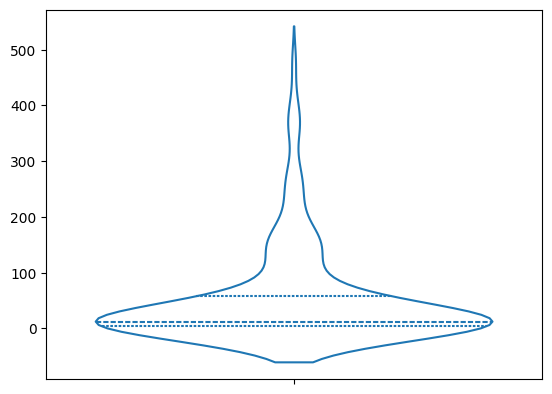

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(list(num_deg.values()), fill=False, inner="quart")

In [3]:
[1,2,3][:-3+1]

[1]

<Axes: ylabel='Count'>

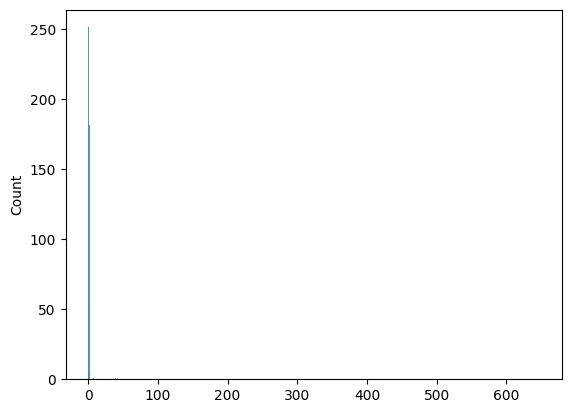

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(x=)

In [2]:
import pandas as pd
import os

NUM_CLASSES = 2
addr2addr = os.path.join(".", "Elliptic++Dataset/AddrAddr_edgelist.csv")
wallets_features_classes = os.path.join(".", "Elliptic++Dataset/wallets_features_classes_combined.csv")

addr2addr_df = pd.read_csv(addr2addr)
wallets_features_classes_df = pd.read_csv(wallets_features_classes)
wallets_features_classes_df["class"] = wallets_features_classes_df["class"].replace([1,2,3],[1,0,2])
wallets_features_classes_df = wallets_features_classes_df[wallets_features_classes_df["class"] != 2] # !!! RAMON TALKED ABOUT THIS, ALSO AUTHORS DO THIS FOR WALLET CLASSIFICATION
    

In [33]:
from collections import defaultdict

time_steps = wallets_features_classes_df["Time step"].unique()
time_steps.sort()

positive_labels = []
negative_labels = []
data = defaultdict(list)
for time_step in time_steps:
    data["timestep"] += [time_step] * 2
    data["label"] += [1]
    data["value"] += [wallets_features_classes_df[wallets_features_classes_df["Time step"] == time_step]["class"].value_counts().to_dict()[1]]
    data["label"] += [0]
    data["value"] += [wallets_features_classes_df[wallets_features_classes_df["Time step"] == time_step]["class"].value_counts().to_dict()[0]]

df = pd.DataFrame(data)

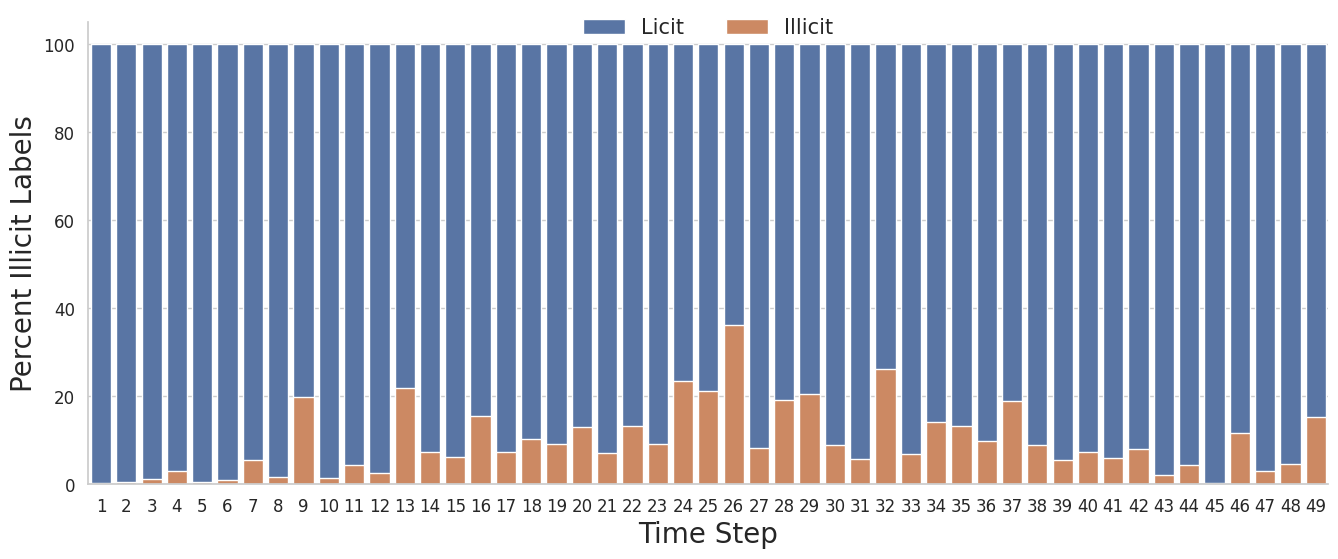

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(16,6))

total_labels = df.groupby("timestep")["value"].sum().reset_index()
procent_positive = df[df["label"] == 1].reset_index()
procent_positive["value"] = [total_positive/total_labels * 100 for total_positive, total_labels in zip(procent_positive["value"], total_labels["value"])]
procent_negative = df[df["label"] == 0].reset_index()
procent_negative["value"] = [total_negative/total_labels * 100 for total_negative, total_labels in zip(total_labels["value"], total_labels["value"])]

sns.barplot(x="timestep", y="value", data=procent_negative, label="Licit")
sns.barplot(x="timestep", y="value", data=procent_positive, label="Illicit")
plt.ylabel("Percent Illicit Labels", fontsize=20)
plt.xlabel("Time Step", fontsize=20)
plt.tick_params(labelsize=12)
plt.legend(frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5,1.05), fontsize=15)
sns.despine()

plt.show()